## Engineering Notebook

---

In this notebook, we analyze the extracted features, assessing the necessity of normalization. We also investigate possible feature selection techniques to reduce the dimensionality of the data.
The sections are organized as follows:

1. [Load Data](#Load-Data)
2. [Feature Analysis](#2.-Feature-Analysis)
    1. [Visualize Features](#2.1.-Visualize-Features)
    2. [Feature correlation](#2.2.-Feature-Correlation)
3. [Covariance analysis](#3-covariance-matrix-of-the-groups)
4. [Feature Selection](#4.-Feature-Selection)
5. [Outliers Detection](#5.-Outliers-Detection)
6. [Feature distribution](#6-Feature-Distribution)
7. [PCA](#7-PCA)
8. [Save the data](#8-Save-Data)



In [13]:
# import all the functions
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys
from scipy.stats import spearmanr
import seaborn as sns

sys.path.append("../")
import pandas as pd
from sklearn.cluster import KMeans

In [14]:
# paths to the features and the labels
FOLDER = "../../features/raw/"
FILE_PATH = (
    FOLDER
    + "full_data_none_bal_1s_4000hz_30mfcc_12chroma_70cqt_41rms_41zcr_41sc_61sb_41sr_FILENAME.npy"
)

THRESH_1 = 0
THRESH_2=0.6
N_FEATURES_CORR=30
feature_names = (
    [f"MFCC {i}" for i in range(1, 31)]
    + [f"Chroma {i}" for i in range(1, 13)]
    + [f"CQT {i}" for i in range(1, 71)]
    + [f"RMS {i}" for i in range(1, 42)]
    + [f"ZCR {i}" for i in range(1, 42)]
    + [f"SC {i}" for i in range(1, 42)]
    + [f"SB {i}" for i in range(1, 62)]
    + [f"SR {i}" for i in range(1, 42)]
)

In [15]:
data=np.load(FILE_PATH, allow_pickle=True).item()
data["test"].keys()

dict_keys(['X', 'y', 'filename'])

In [16]:
def remove_features(data, data_df, features_to_drop, file_path):
    # Drop the identified features from the dataset
    indexes = data_df.columns.get_indexer(features_to_drop)
    print("Removing features from the dataset")
    filtered_data = data
    # Check if the file path indicates posterior or both types of data
    # Load the data from the file and extract the "train_bal" subset
    for key in filtered_data.keys():
        filtered_data[key]["X"] = np.delete(
            filtered_data[key]["X"], indexes, axis=1
        )
        print(filtered_data[key]["X"].shape)
    return filtered_data


def remove_highly_correlated_features(
    correlation_matrix_comp: pd.DataFrame,
    correlation_matrix_no_target: pd.DataFrame,
    target_variable: str = "label",
    threshold: float = 0.7,
    max_corr_count: int = 4,
) -> list:
    """
    Remove highly correlated features based on correlation matrix.

    Parameters:
        correlation_matrix_comp (pd.DataFrame): Complete correlation matrix including the target variable.
        correlation_matrix_no_target (pd.DataFrame): Correlation matrix without the target variable.
        target_variable (str): The name of the target variable.
        threshold (float): Threshold above which features are considered highly correlated.
        max_corr_count (int): Maximum number of highly correlated features to keep.

    Returns:
        List[str]: List of features to remove.
    """
    features_to_remove = set()

    # Iterate through each feature
    for feature in correlation_matrix_no_target.columns:
        # Count the number of features with correlation higher than threshold
        correlated_count = (correlation_matrix_no_target[feature] > threshold).sum()
        # If the count is greater than the maximum allowed count
        if correlated_count > max_corr_count:
            # Get the correlations of the highly correlated features with the target variable
            target_correlations = correlation_matrix_no_target.loc[feature]
            candidates = target_correlations[target_correlations > threshold].index
            best = (
                correlation_matrix_comp.loc[candidates, target_variable].abs().idxmax()
            )
            features_to_remove.update(candidates.difference([best]))

    # Remove the highly correlated features
    print(f" {len(features_to_remove)} features should be removed")
    return list(features_to_remove)


def read_file(file_path: str, feature_names: list):

    dataset = []  # Initialize an empty list to store dataset
    data = None  # Initialize data to None

    # Check if the file path indicates posterior or both types of data
    # Load the data from the file and extract the "train_bal" subset
    data = np.load(file_path, allow_pickle=True).item()
    datam = data["train"]

    # Separate features (X) and labels (y), then concatenate them into one array
    X = datam["X"]
    y = datam["y"].reshape(-1, 1)
    dataset = np.concatenate((X, y), axis=1)

    # Convert the dataset into a pandas DataFrame with feature names and label
    data_df = pd.DataFrame(dataset, columns=feature_names + ["label"])

    return data, data_df

data, data_df = read_file(FILE_PATH, feature_names)

### 2. Feature Analysis


#### 2.1. Visualize Features


In [17]:
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MFCC 1,3904.0,-285.551923,151.594091,-1131.369629,-358.904396,-245.222282,-202.352257,167.382248
MFCC 2,3904.0,84.139773,48.929864,-82.786201,58.001386,93.403816,117.924080,192.768066
MFCC 3,3904.0,8.054007,30.512217,-125.690163,-9.357538,9.311171,23.939860,111.745430
MFCC 4,3904.0,16.396567,25.996405,-93.636551,0.798443,23.367419,35.273933,83.714844
MFCC 5,3904.0,-4.242304,14.979377,-83.115410,-13.825295,-2.813711,5.821800,75.060608
...,...,...,...,...,...,...,...,...
SR 38,3904.0,796.680328,450.893092,0.000000,420.000000,760.000000,1120.000000,1900.000000
SR 39,3904.0,797.976434,452.417316,0.000000,440.000000,760.000000,1140.000000,1940.000000
SR 40,3904.0,801.813525,453.690523,0.000000,420.000000,780.000000,1140.000000,1900.000000
SR 41,3904.0,964.815574,369.616994,0.000000,720.000000,960.000000,1220.000000,1940.000000


#### 2.2. Feature Correlation


#### Test Normalità


In [18]:
import scipy.stats as stats

p_values = []
test_val = []

# Calcola il test di normalità per ciascuna colonna del dataframe
for column in data_df.columns:
    test = stats.normaltest(data_df[column])
    p_values.append(test[1])
    test_val.append(test[0])

# Crea un dataframe contenente i risultati del test di normalità
norm_df = pd.DataFrame(
    {"Feature": data_df.columns, "D'Agostino-Pearson": test_val, "P-value": p_values}
)

norm_df.set_index("Feature", inplace=True)


# Definisci una funzione per colorare le celle in base al p-value
def color_cells(val):
    color = (
        "green" if val >= 0.05 else "red"
    )  # Assumendo un livello di significatività del 0.05
    if val > 1:
        color = None
    return "background-color: %s" % color


# Applica la funzione di colorazione al DataFrame
styled_norm_df = norm_df.style.applymap(color_cells)

styled_norm_df

/tmp/ipykernel_71277/3873497847.py:31: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_norm_df = norm_df.style.applymap(color_cells)


,D'Agostino-Pearson,P-value
Feature,,
MFCC 1,1643.661026,0.000000
MFCC 2,275.972507,0.000000
MFCC 3,138.593262,0.000000
MFCC 4,505.812654,0.000000
MFCC 5,248.836950,0.000000
MFCC 6,216.386709,0.000000
MFCC 7,1608.601719,0.000000
MFCC 8,359.359375,0.000000
MFCC 9,635.304329,0.000000


#### Compute the correlation coefficient between the features and the target variable.


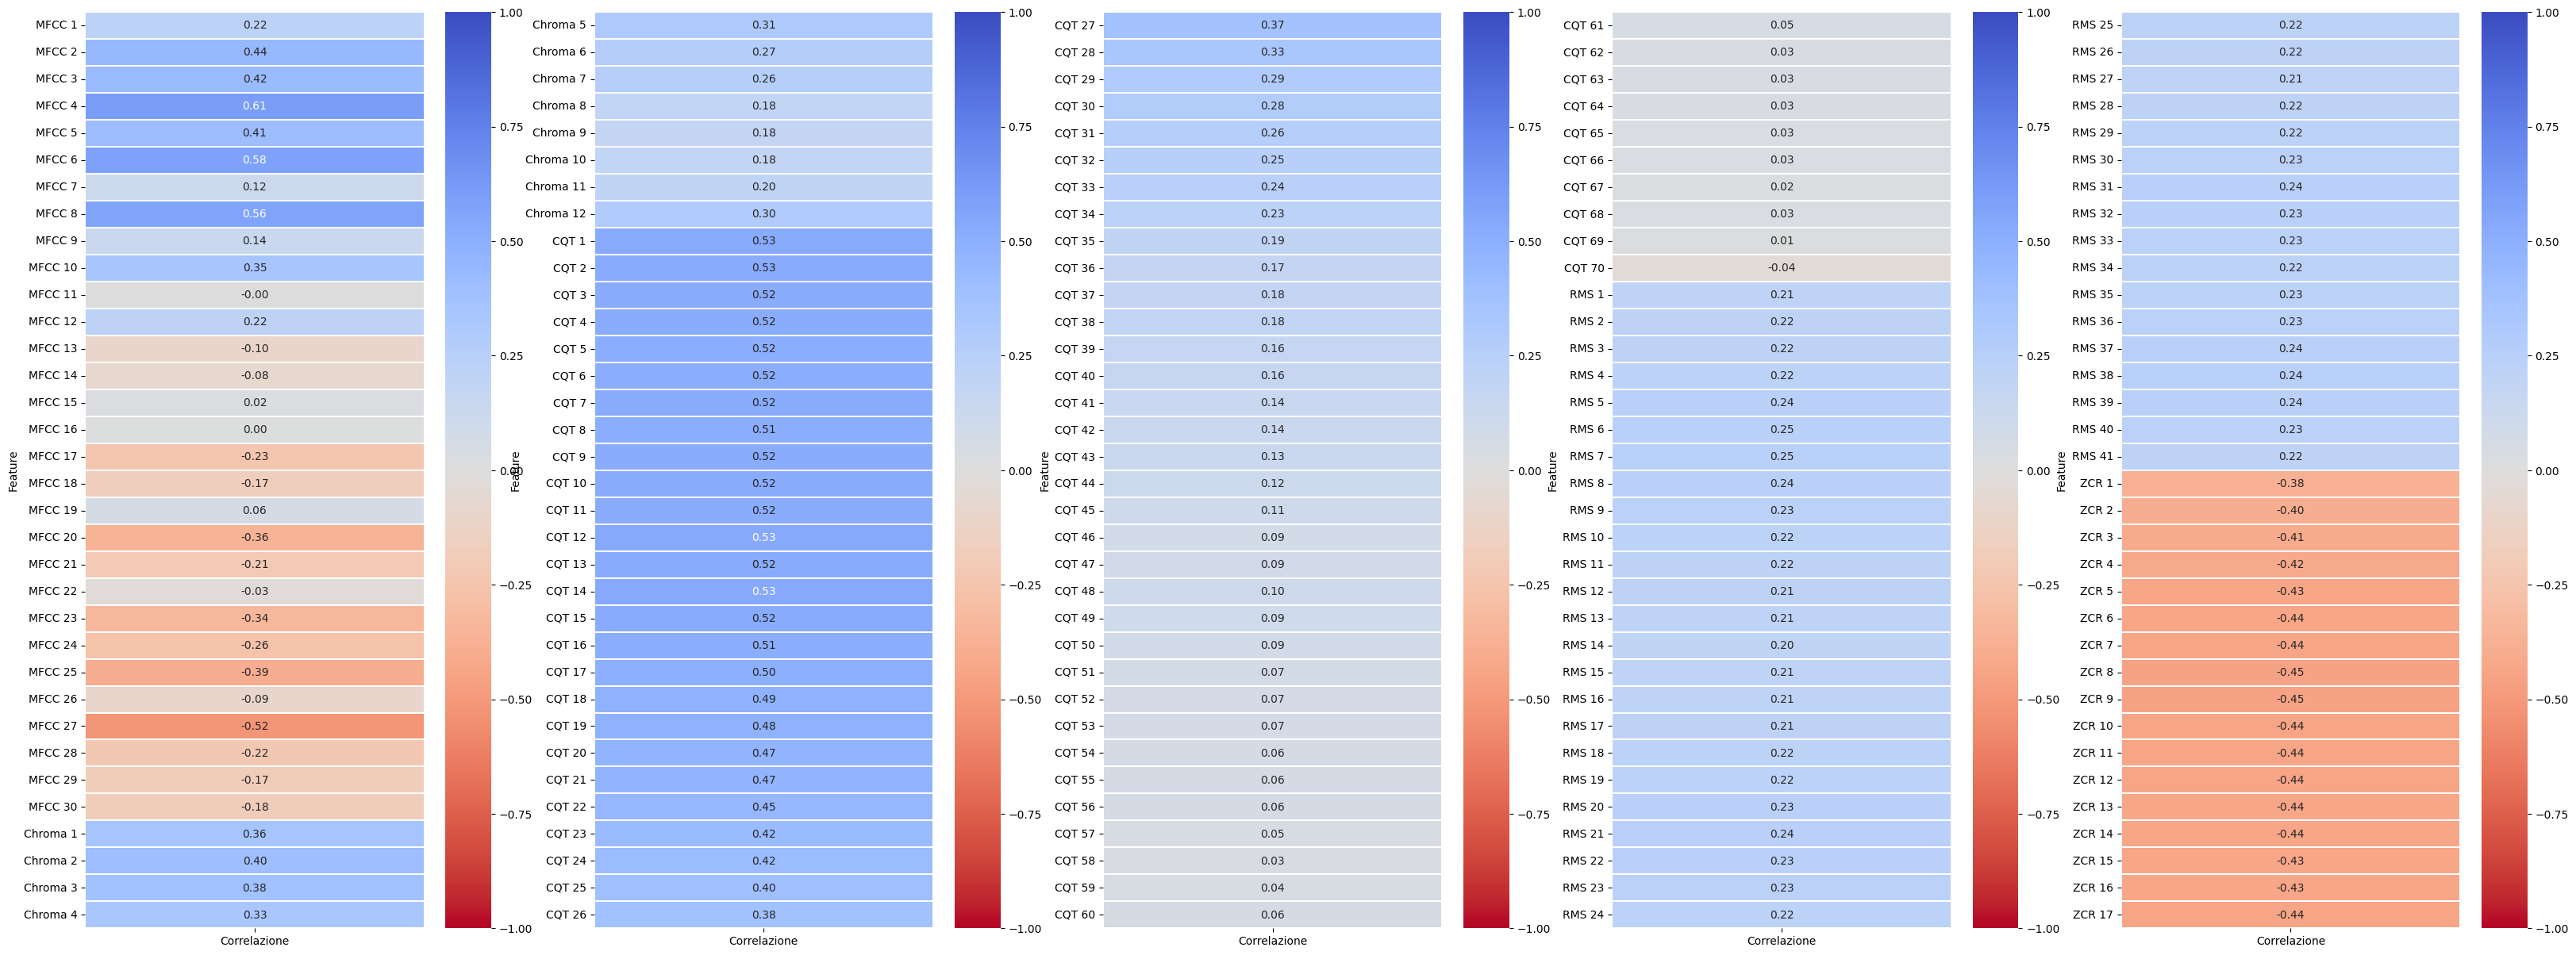

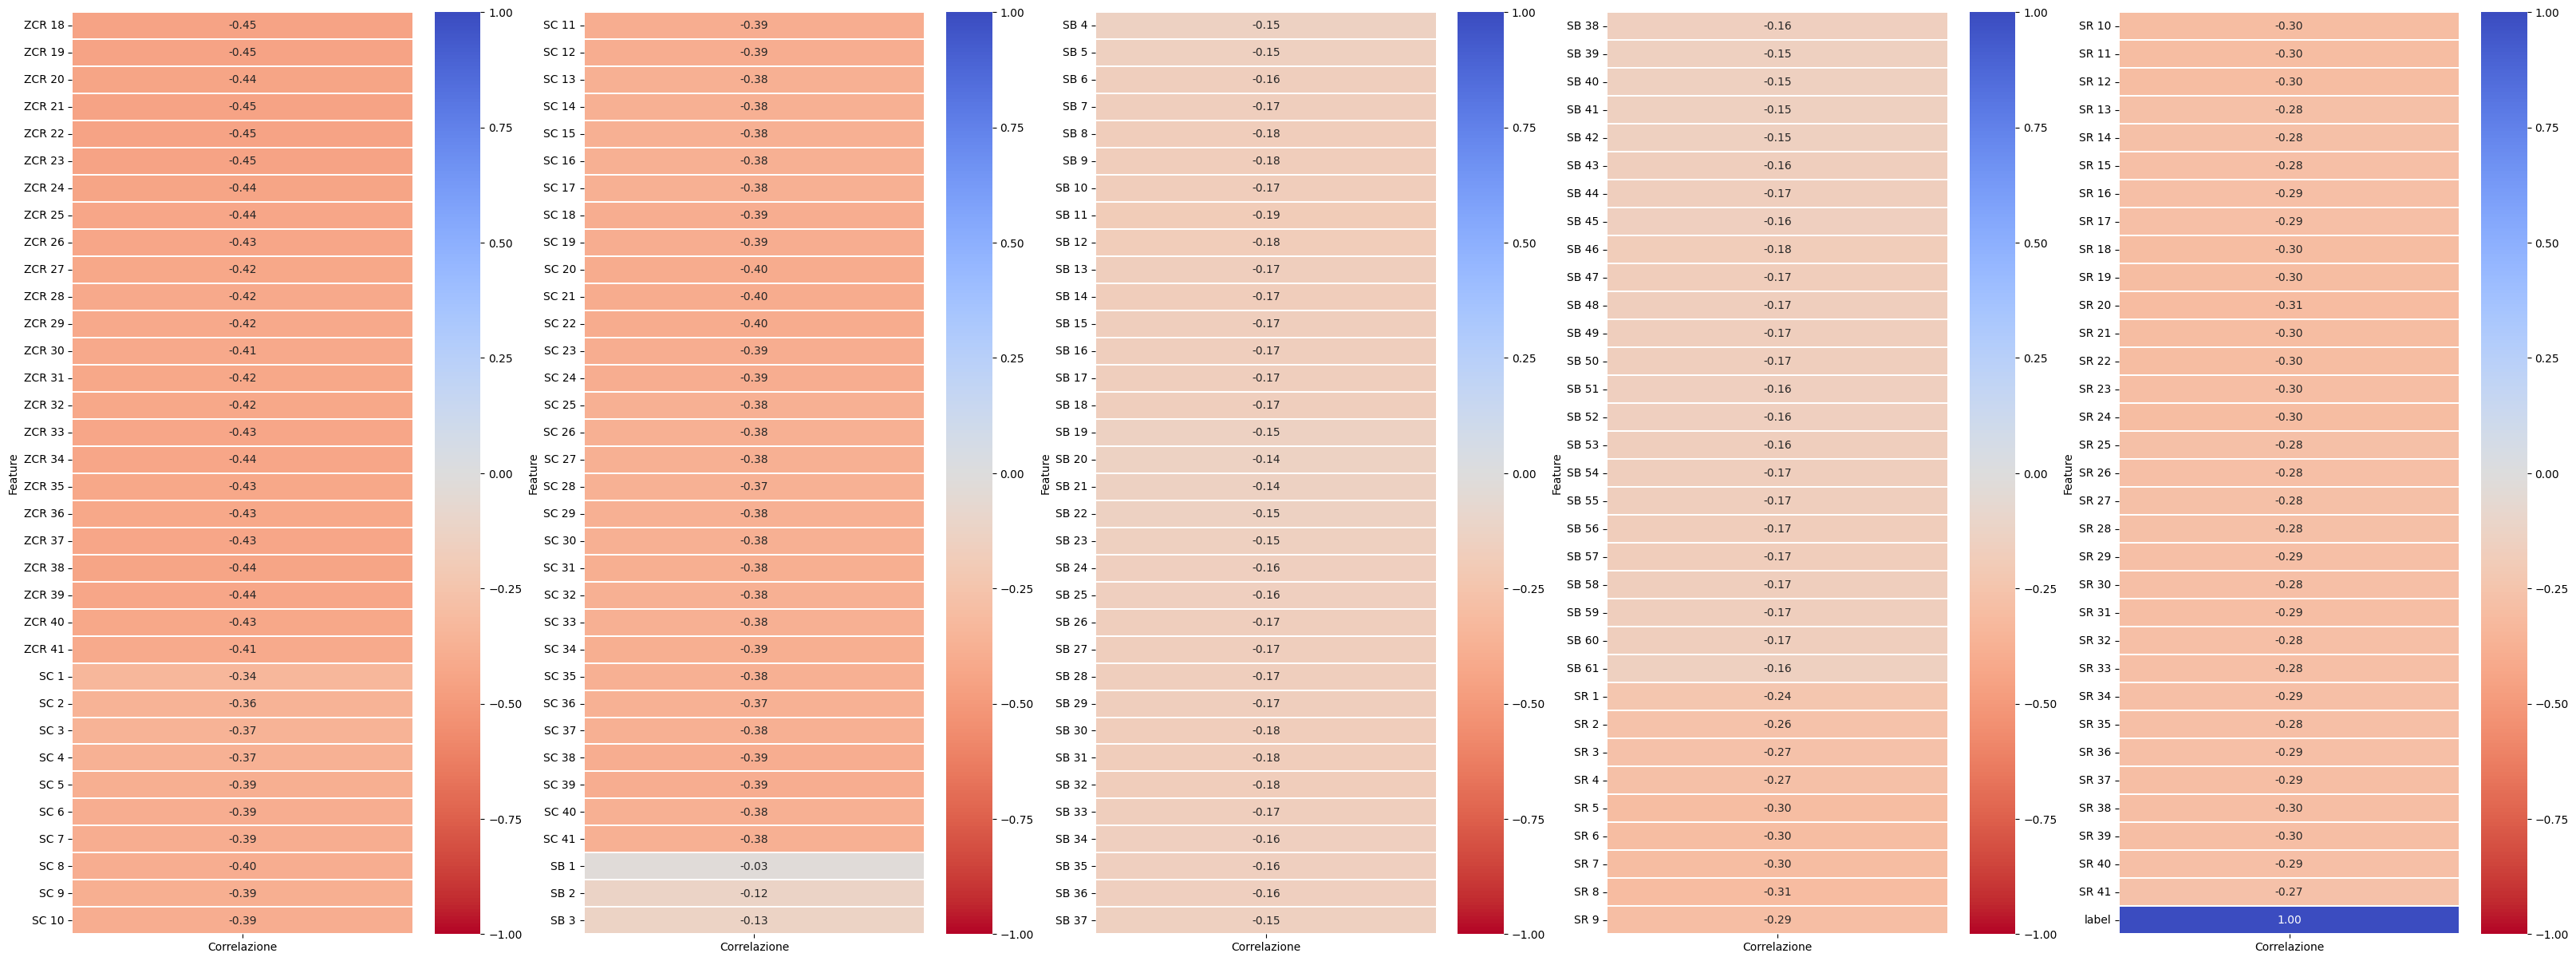

In [19]:
columns = data_df.columns
# Importa le librerie necessarie

groups = np.array_split(columns, 10)
corr_df=pd.DataFrame(index=columns, columns=["Correlation"])
corr_5 = []
feature_5=[]
for group in groups:
    correlazione = []
    features = []
    for col1 in group:
        correlation, p_value = spearmanr(data_df[col1], data_df["label"])
        correlazione.append(correlation)
        corr_df.loc[col1, "Correlation"] = correlation
        features.append(col1)
    corr_5.append(correlazione)
    feature_5.append(features)

    if len(corr_5) == 5:
        fig, axes = plt.subplots(1, 5, figsize=(40, 15))  # Creating a 5x5 subplot grid
        for i, ax in enumerate(axes.flat):
            correlazione_df = pd.DataFrame(
                {"Feature": feature_5[i], "Correlazione": corr_5[i]}
            )
            correlazione_df.set_index("Feature", inplace=True)
            sns.heatmap(correlazione_df, annot=True, fmt=".2f", cmap="coolwarm_r",linewidths=0.1, ax=ax, cbar=True, vmin=-1, vmax=1)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        plt.show()
        corr_5 = []
        feature_5 = []


In [20]:
# Importa le librerie necessarie
p_values = []
correlazione = []
features = []
# Calcola i coefficienti di correlazione di Kendall e i valori p per ogni coppia di colonne nel dataframe
for col1 in data_df.columns:
    correlation, p_value = spearmanr(data_df[col1], data_df["label"])
    p_values.append(p_value)
    correlazione.append(correlation)
    features.append(col1)

correlazione_df = pd.DataFrame(
    {"Feature": features, "Correlazione": correlazione, "P-value": p_values}
)

correlazione_df.set_index("Feature", inplace=True)


Remove features with low correlation with the target variable.

In [21]:
features_slightly_corr = correlazione_df[np.abs(correlazione_df["Correlazione"]) <=THRESH_1].index
print(len(features_slightly_corr))


0


In [22]:
print(len(data_df.columns))
print(data_df.columns)

338
Index(['MFCC 1', 'MFCC 2', 'MFCC 3', 'MFCC 4', 'MFCC 5', 'MFCC 6', 'MFCC 7',
       'MFCC 8', 'MFCC 9', 'MFCC 10',
       ...
       'SR 33', 'SR 34', 'SR 35', 'SR 36', 'SR 37', 'SR 38', 'SR 39', 'SR 40',
       'SR 41', 'label'],
      dtype='object', length=338)


### 4 Feature Selection
Remove the features that are highly correlated with each other.
Like 'Spectral centroid' and 'Spectral bandwidth' and 'Spectral rolloff'

In [23]:

correlation_matrix = data_df.corr(method="spearman")
correlation_matrix_no_target = data_df.drop(columns=["label"]).corr(method="spearman")
highly_corr_each = remove_highly_correlated_features(
    correlation_matrix, correlation_matrix_no_target, threshold=THRESH_2, max_corr_count=N_FEATURES_CORR
)


 296 features should be removed


### 8. Save Data

In [24]:
remove1 = set(features_slightly_corr)
remove2 = set(highly_corr_each)
features_to_drop = remove1.union(remove2)
print("features to drop : ",len(features_to_drop))
filtered_data = remove_features(data, data_df, features_to_drop, FILE_PATH)

filtered_df = data_df.drop(columns=features_to_drop)
feat_names = ["MFCC", "Chroma", "CQT", "RMS", "ZCR", "SC", "SB", "SR"]
feat_count = []
filename = "full_data_filtered_1s_4000hz_"
for name in feat_names:
    feat_count.append(len([col for col in filtered_df.columns if name in col]))
    filename=filename+str(feat_count[-1])+str.lower(name)+"_"
    print(f"{name}: {feat_count[-1]}")
filename=filename+".npy"

features = filtered_df.drop(columns="label").columns

print("Features to keep: ", features)
filtered_data["features"] = features
filtered_data["train"]["filename"] = data["train"]["filename"]
filtered_data["test"]["filename"] = data["test"]["filename"]
print("Saving filtered data")
# Construct the full file path for the current feature file
save_file_path = os.path.join(
    FOLDER,
    filename,
)
np.save(save_file_path, filtered_data)

features to drop :  296
Removing features from the dataset
(3904, 41)
(976, 41)
MFCC: 28
Chroma: 12
CQT: 0
RMS: 0
ZCR: 1
SC: 0
SB: 0
SR: 0
Features to keep:  Index(['MFCC 3', 'MFCC 4', 'MFCC 5', 'MFCC 6', 'MFCC 7', 'MFCC 8', 'MFCC 9',
       'MFCC 10', 'MFCC 11', 'MFCC 12', 'MFCC 13', 'MFCC 14', 'MFCC 15',
       'MFCC 16', 'MFCC 17', 'MFCC 18', 'MFCC 19', 'MFCC 20', 'MFCC 21',
       'MFCC 22', 'MFCC 23', 'MFCC 24', 'MFCC 25', 'MFCC 26', 'MFCC 27',
       'MFCC 28', 'MFCC 29', 'MFCC 30', 'Chroma 1', 'Chroma 2', 'Chroma 3',
       'Chroma 4', 'Chroma 5', 'Chroma 6', 'Chroma 7', 'Chroma 8', 'Chroma 9',
       'Chroma 10', 'Chroma 11', 'Chroma 12', 'ZCR 22'],
      dtype='object')
Saving filtered data


In [25]:
filtered_df

,MFCC 3,MFCC 4,MFCC 5,MFCC 6,MFCC 7,MFCC 8,MFCC 9,MFCC 10,MFCC 11,MFCC 12,...,Chroma 5,Chroma 6,Chroma 7,Chroma 8,Chroma 9,Chroma 10,Chroma 11,Chroma 12,ZCR 22,label
0,8.789787,18.247793,-8.188979,9.443937,-17.088078,4.299743,-5.840672,3.867532,-3.186062,5.024307,...,0.566009,0.599769,0.631813,0.560878,0.488417,0.755780,0.578864,0.426935,0.120,3.0
1,20.361849,32.982029,-5.257621,14.309803,-17.100214,12.650185,-4.732724,0.975971,-6.364773,7.584736,...,0.617049,0.694165,0.803996,0.893595,0.730133,0.592283,0.609951,0.729562,0.130,3.0
2,27.943064,2.459366,-13.357094,-17.651798,-20.450172,-15.346375,-7.786088,0.978249,-0.926832,0.849646,...,0.621314,0.606870,0.591282,0.588234,0.477400,0.375447,0.432177,0.583936,0.245,1.0
3,-5.439257,-11.083915,-21.040472,-31.193333,-31.339621,-13.059542,-19.743843,-17.605721,-14.650146,-14.022894,...,0.414739,0.243504,0.260472,0.196406,0.160679,0.366509,0.629301,0.513821,0.070,0.0
4,11.008063,39.546917,14.514465,12.670250,-10.951449,16.324484,0.532214,1.597042,-6.052132,3.419728,...,0.663321,0.585920,0.457656,0.325609,0.311652,0.408441,0.461968,0.528469,0.060,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3899,12.054921,24.285734,-20.335367,8.013477,-3.855657,5.987661,-5.415478,9.091759,-0.067376,6.229473,...,0.614540,0.780790,0.784015,0.826137,0.758558,0.641630,0.614211,0.517404,0.085,3.0
3900,-43.098980,-19.950172,-45.708637,-23.392166,-44.249607,-21.702768,-11.140663,-2.810637,-7.299947,1.257363,...,1.000000,0.230994,0.063311,0.042623,0.038802,0.040017,0.074702,0.226541,0.095,0.0
3901,13.180221,41.786442,3.294466,12.477217,-6.814918,18.088638,-0.631328,9.932405,-2.444104,2.980216,...,0.806306,0.705275,0.622559,0.587687,0.576296,0.691854,0.770527,0.800284,0.065,3.0
3902,-26.595842,10.741345,3.101536,16.802034,-6.638947,13.885021,-9.777659,1.266639,-8.129613,1.164601,...,0.636235,0.720940,0.786972,0.736132,0.743033,0.704358,0.861051,0.837912,0.130,3.0


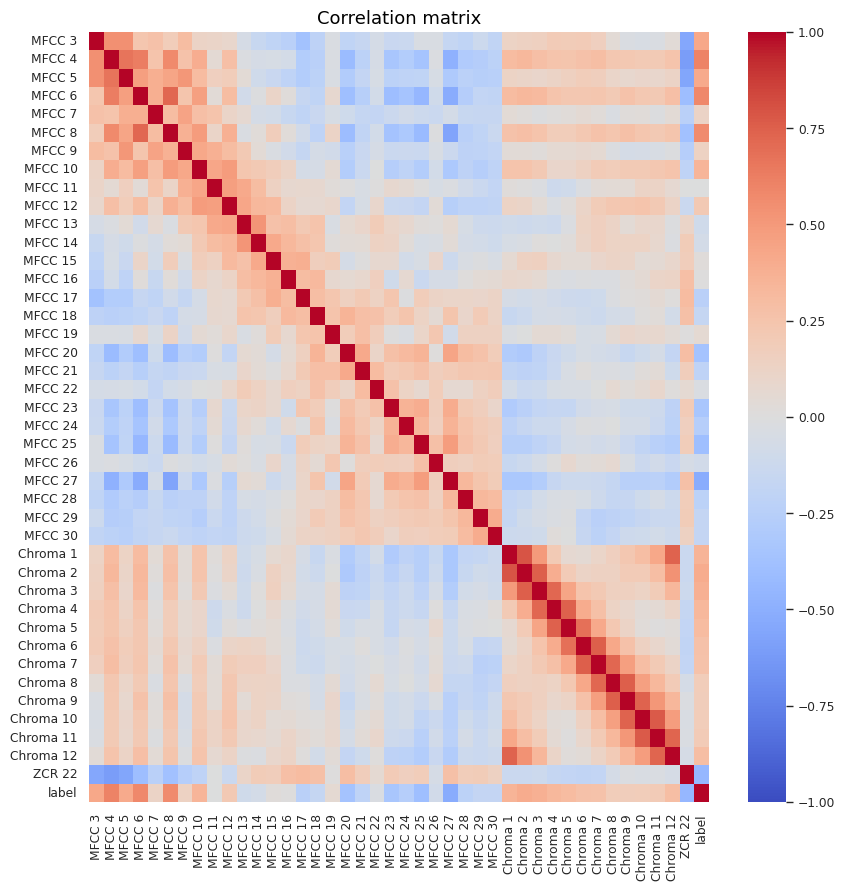

In [26]:
plt.figure(figsize=(10, 10))
sns.set_theme(context="paper", font_scale=1)

sns.heatmap(filtered_df.corr(method="spearman"), annot=False, fmt=".1", cmap="coolwarm", cbar=True, vmin=-1, vmax=1)
plt.yticks(rotation=0)
plt.title("Correlation matrix", fontsize=13, color="black")
plt.show()


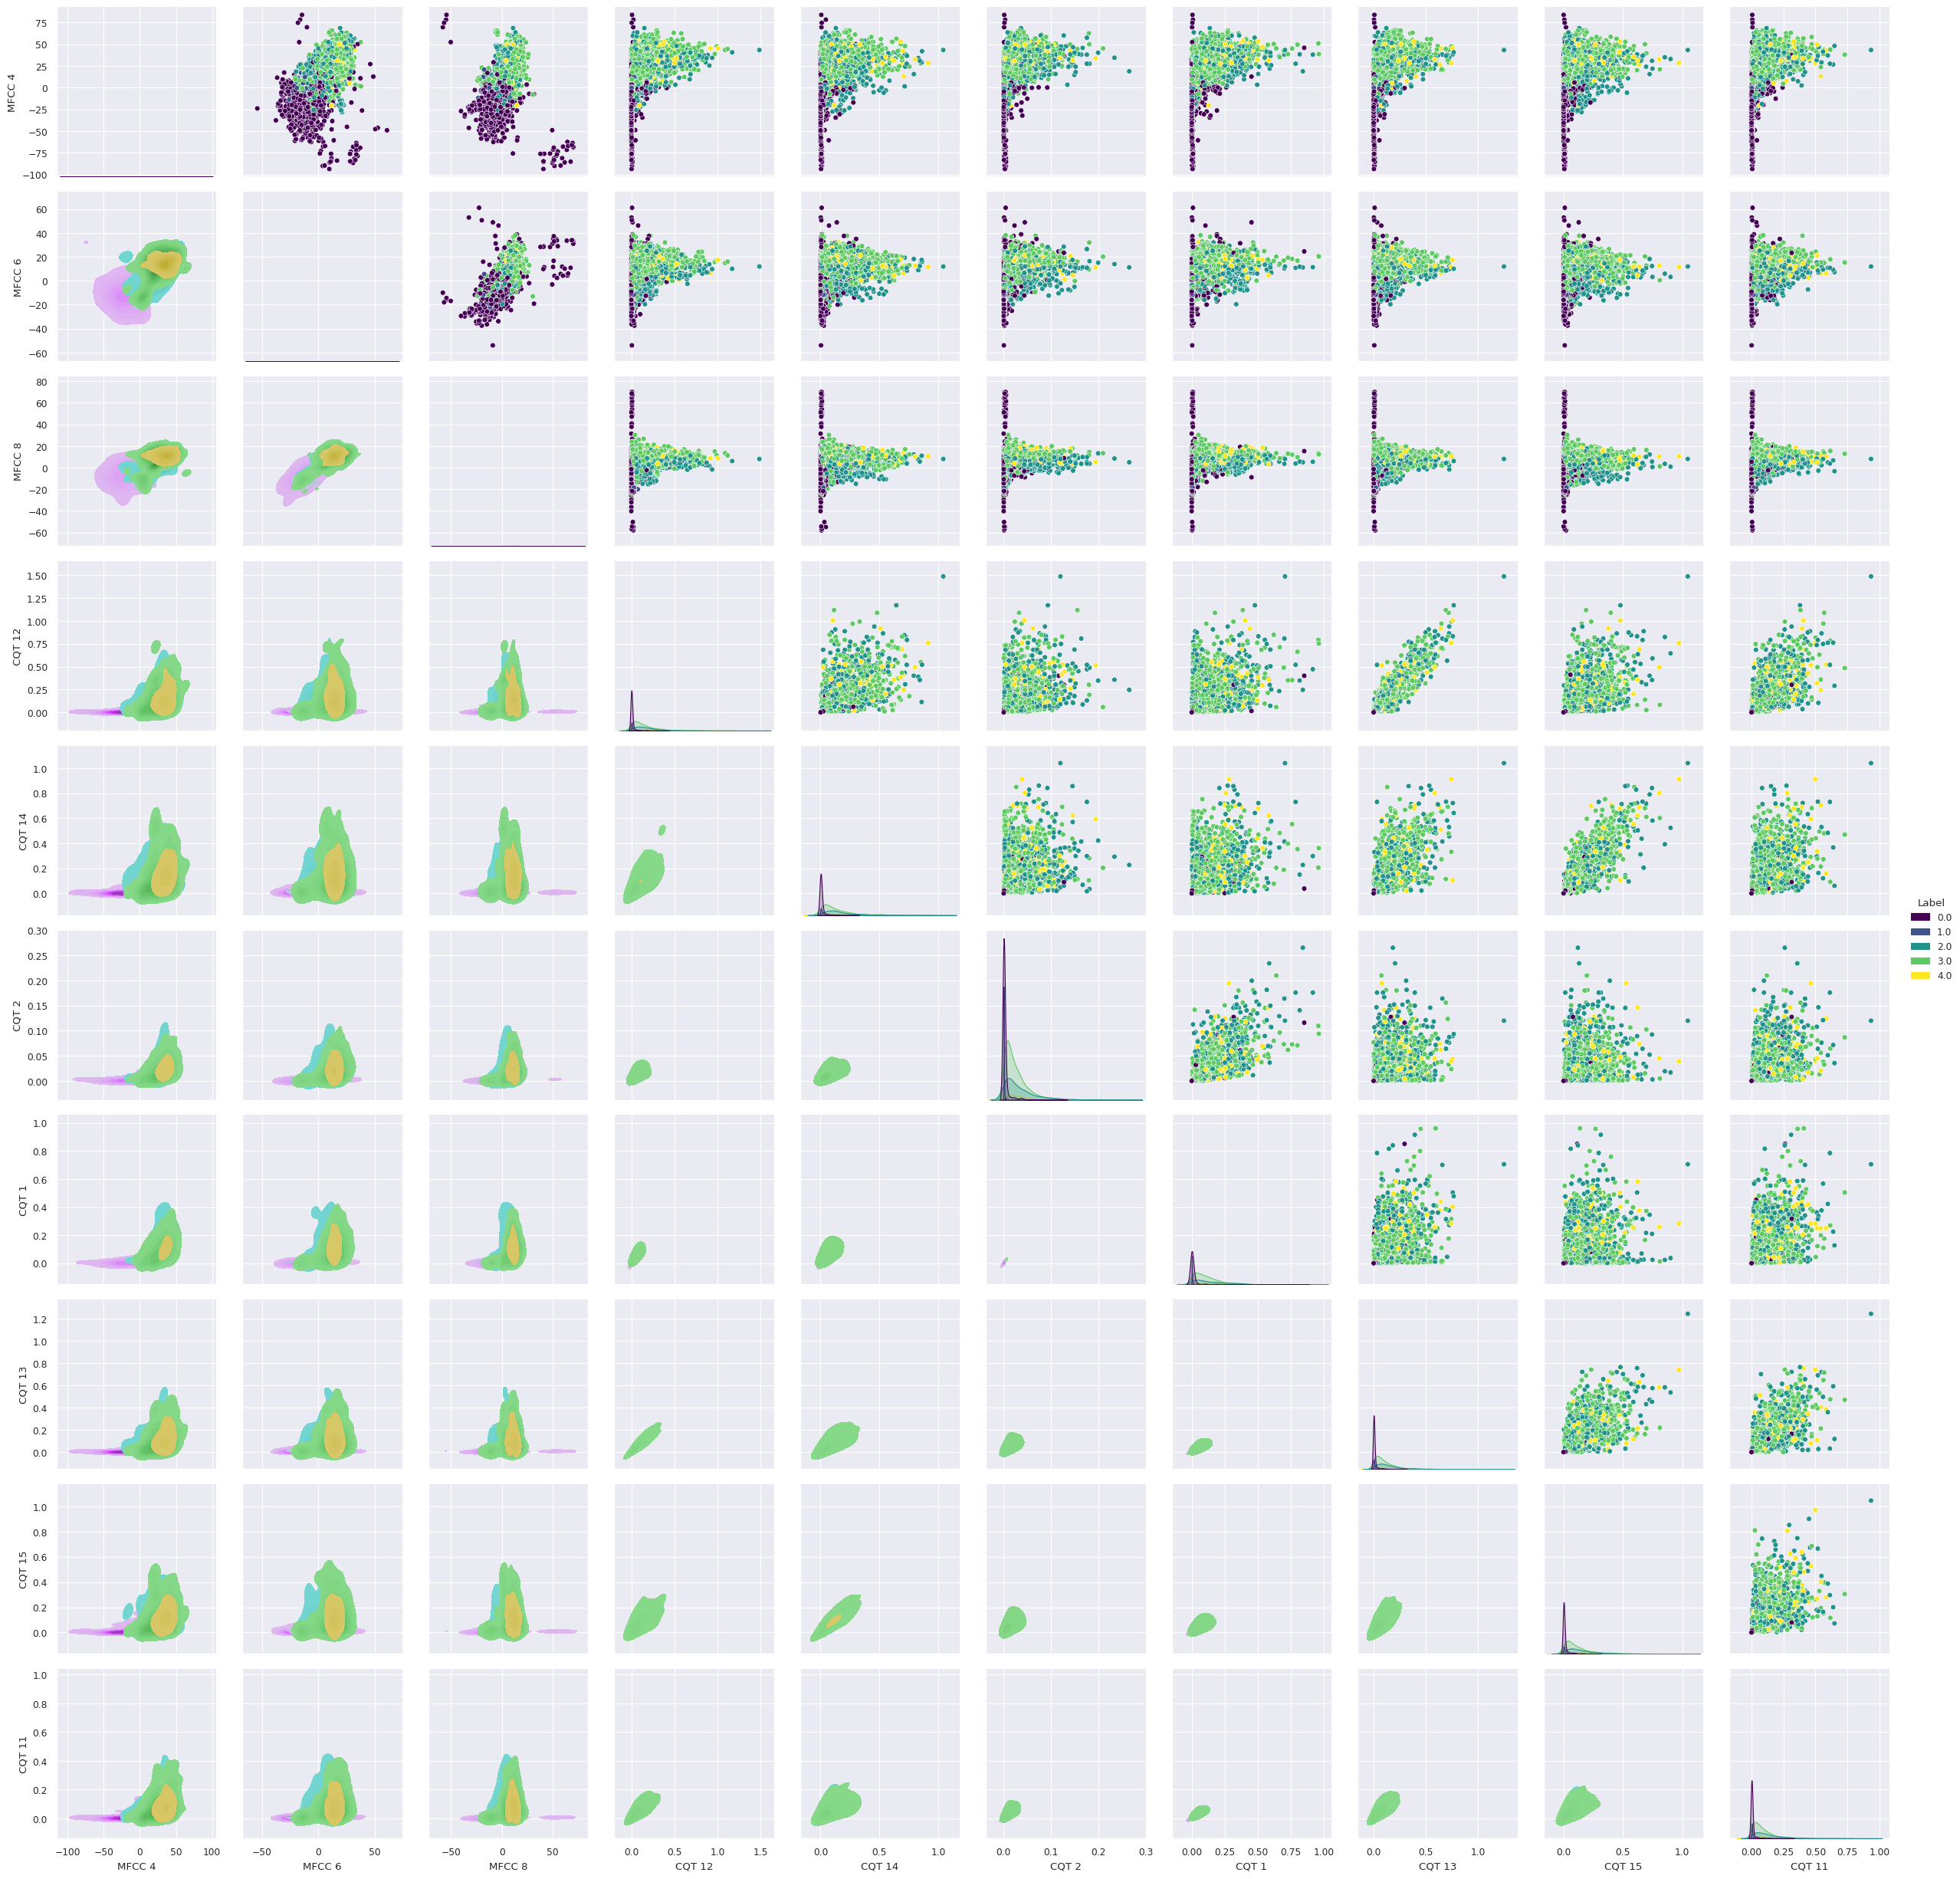

In [27]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for plotting

corr_df.sort_values(by="Correlation", ascending=False, inplace=True)

best_features = corr_df.index[0:11]

# Create a DataFrame with the best features
group1 = data_df[best_features]
# Create a PairGrid for the selected features
g = sns.PairGrid(group1, hue="label", palette="viridis")
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.kdeplot, fill=True)
g.add_legend(title="Label")

# Display the plot
plt.show()

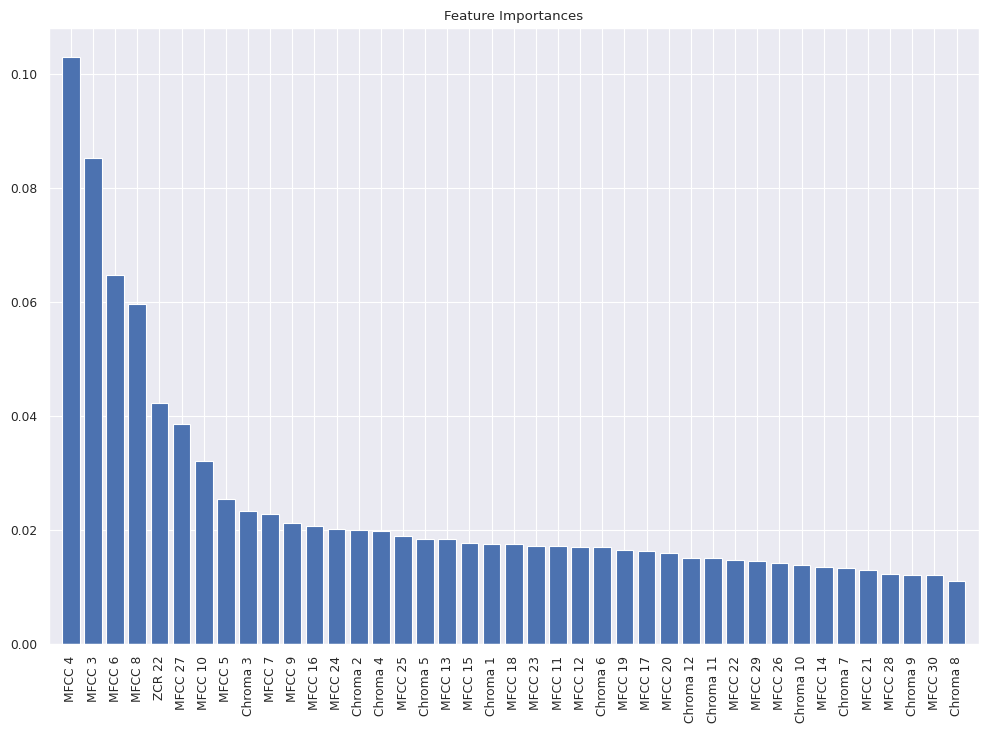

In [28]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Assuming 'X' is your features DataFrame and 'y' is your target variable
# Generate random target variable for illustration
y=filtered_df["label"]
# Train a RandomForest model
model = RandomForestClassifier()
model.fit(filtered_df.drop(columns=["label"] ), y)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(filtered_df.drop(columns=["label"] ).shape[1]), importances[indices], align="center")
plt.xticks(range(filtered_df.drop(columns=["label"] ).shape[1]), [filtered_df.drop(columns=["label"] ).columns[i] for i in indices], rotation=90)
plt.xlim([-1, filtered_df.drop(columns=["label"] ).shape[1]])
plt.show()